In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import dask.array as da
import dask.bag as db
import matplotlib as plt

In [2]:
persons = dd.read_csv(r'C:\Users\jchu\OneDrive - San Diego Association of Governments\Projects\2023\2023-034 PopulationSim Outputs QC\Data\synthetic_persons_2022_01.csv',
                      dtype={'NAICS2': 'object'},
                      blocksize=25e6)
print((persons.shape[0].compute(), persons.shape[1]))
persons.head()

(3282404, 17)


,mgra,household_id,SPORDER,AGEP,SEX,ESR,COW,WKHP,SCHG,RAC1P,HISP,MIL,SCHL,OCCP,WKW,NAICS2,SOC2
0,57,1,1,64,2,1.0,2.0,15.0,0,9,23,4.0,21.0,2050.0,1.0,81,21
1,57,1,2,29,1,1.0,1.0,40.0,0,9,3,4.0,19.0,4700.0,1.0,44,41
2,57,1,3,62,2,6.0,0.0,0.0,0,9,23,4.0,19.0,0.0,0.0,0,0
3,57,2,1,64,2,6.0,0.0,0.0,0,1,1,4.0,19.0,0.0,0.0,0,0
4,57,3,1,56,2,1.0,6.0,30.0,0,1,2,4.0,1.0,4230.0,2.0,81,37


In [3]:
households = dd.read_csv(r'C:\Users\jchu\OneDrive - San Diego Association of Governments\Projects\2023\2023-034 PopulationSim Outputs QC\Data\synthetic_households_2022_01.csv',
                      blocksize=25e6)
print((households.shape[0].compute(), households.shape[1]))
households.head()

(1276883, 10)


,household_id,mgra,NP,HHADJINC,HHT,WIF,HUPAC,VEH,BLD,GQ_type
0,1,57,3,87344.7,3.0,2.0,4.0,1.0,6.0,0.0
1,2,57,1,39633.6,6.0,NaN,4.0,1.0,3.0,0.0
2,3,57,3,35541.0,1.0,1.0,4.0,5.0,3.0,0.0
3,4,57,3,35541.0,1.0,1.0,4.0,5.0,3.0,0.0
4,5,57,2,56865.6,1.0,0.0,4.0,3.0,2.0,0.0


# 8.1 ESR b, 3, 6 have 'isWorker' !=0

Check for records in which `ESR` is less than 16 yo (`0`) or unemployed (`3`) or not in labor force (`6`) and their `isWorker` code is `0`.

In [4]:
# Number of persons that has no ESR code
persons[persons['ESR'].isna()].shape[0].compute()

0

In [5]:
# Only taking records where ESR is 0, 3, 6: less than 16, unemployed, or not in labor force
ESRb36 = persons[(persons['ESR'] == 0) | (persons['ESR'] == 3) | (persons['ESR'] == 6)]

# Checking to see if any other column codes for `isWorker`
cow = ESRb36['COW'].unique()
wkhp = ESRb36['WKHP'].unique()
occp = ESRb36['OCCP'].unique()
wkw = ESRb36['WKW'].unique()

print(cow.compute(), wkhp.compute(), occp.compute(), wkw.compute())

0    0.0
1    9.0
2    1.0
3    5.0
4    6.0
5    2.0
6    3.0
7    4.0
8    7.0
9    8.0
Name: COW, dtype: float64 0      0.0
1     12.0
2     50.0
3     40.0
4      1.0
      ... 
65    26.0
66    52.0
67    98.0
68    54.0
69    62.0
Name: WKHP, Length: 70, dtype: float64 0         0.0
1      9920.0
2      4850.0
3      7210.0
4      4840.0
        ...  
469    7610.0
470    3321.0
471    3647.0
472    4640.0
473    6460.0
Name: OCCP, Length: 474, dtype: float64 0    0.0
1    6.0
2    4.0
3    5.0
4    1.0
5    2.0
6    3.0
Name: WKW, dtype: float64


# 8.2 ESR b have age > 16 

Check for records in which `ESR` is less than 16 (`0`), but `AGEP` is greater than than 16.

In [6]:
# Number of persons that have an ESR of 0 (less than 16 y/o), but AGEP greater than or equal to 16
persons[(persons['ESR'] == 0) & persons['AGEP'] >= 16].shape[0].compute()

0

# 8.3 ESR b has COW of b 
Check for records in which `ESR` is less than 16 (`0`), but `COW` is in the universe (not `0`).

In [7]:
# Number of persons that have an ESR of 0 (less than 16 y/o), but has a COW status
persons[(persons['ESR'] == 0) & persons['COW'] != 0].shape[0].compute()

0

# 8.4 ESR 3 or 6 have 'isWorker' != 0
Check is removed due to missing `isWorker` column.

# 8.5 ESR b or 3 or 6 don't have COW of b or 9 (b= NAN) 
Check for records in which `ESR` is less than 16 yo (`0`) or unemployed (`3`) or not in labor force (`6`) and their `COW` is in the universe and employed (not `0` or `9`).

### FLAGED AS FALSE. Data contains records with ESR 3 and 6 with COW neither 0 nor 9

In [8]:
# Number of persons where ESR is 0, 3, 6: less than 16, unemployed, or not in labor force
# But has a COW code that is neither 0 nor 9 (not in universe nor unemployed/last worked 5 years/never worked)
ESRb36[~((ESRb36['COW'] == 0) | (ESRb36['COW'] == 9))].shape[0].compute()

197351

In [9]:
# ESR codes of 3 and 6 contain COW codes that are neither 0 nor 9
ESRb36[~((ESRb36['COW'] == 0) | (ESRb36['COW'] == 9))]['ESR'].unique().compute()

0    6.0
1    3.0
Name: ESR, dtype: float64

In [10]:
# COW codes vary between 1 to 8 for these ESR codes
ESRb36[~((ESRb36['COW'] == 0) | (ESRb36['COW'] == 9))]['COW'].unique().compute()

0    1.0
1    5.0
2    6.0
3    2.0
4    3.0
5    4.0
6    7.0
7    8.0
Name: COW, dtype: float64

In [11]:
ESRb36[~((ESRb36['COW'] == 0) | (ESRb36['COW'] == 9))].head()

,mgra,household_id,SPORDER,AGEP,SEX,ESR,COW,WKHP,SCHG,RAC1P,HISP,MIL,SCHL,OCCP,WKW,NAICS2,SOC2
17,57,8,3,27,2,6.0,1.0,12.0,0,1,1,4.0,18.0,4850.0,6.0,32,41
21,57,9,3,27,2,6.0,1.0,12.0,0,1,1,4.0,18.0,4850.0,6.0,32,41
24,57,10,2,25,2,6.0,5.0,12.0,15,1,1,2.0,19.0,7210.0,4.0,92,49
25,57,10,3,22,1,6.0,1.0,50.0,15,1,1,2.0,19.0,4840.0,6.0,44,41
31,57,14,1,69,1,6.0,6.0,40.0,0,9,2,4.0,7.0,4251.0,5.0,56,37


In [12]:
# output results of checks
pd.DataFrame(ESRb36[~((ESRb36['COW'] == 0) | (ESRb36['COW'] == 9))]).to_csv('persons_ESRb36_COW_no_b_9.csv', index=False)

# 8.6 Range of hours worked for ESR 1 and 4 and ESR 2 and 5 is reasonable 

count    1.513777e+06
mean     4.037509e+01
std      1.226280e+01
min      1.000000e+00
25%      4.000000e+01
50%      4.000000e+01
75%      5.500000e+01
max      9.900000e+01
Name: WKHP, dtype: float64


<AxesSubplot:>

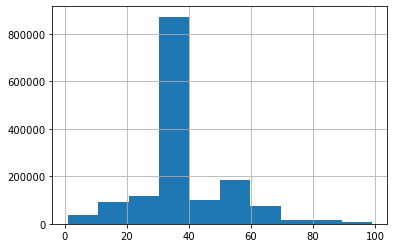

In [13]:
# Check range of hours for persons with ESR 1 or 4: at work civilians or armed forces
print(persons[(persons['ESR'] == 1) | (persons['ESR'] == 4)]['WKHP'].describe().compute())
pd.Series(persons[(persons['ESR'] == 1) | (persons['ESR'] == 4)]['WKHP']).hist()

count    35005.000000
mean        36.149236
std         15.246967
min          1.000000
25%         35.000000
50%         40.000000
75%         40.000000
max         99.000000
Name: WKHP, dtype: float64


<AxesSubplot:>

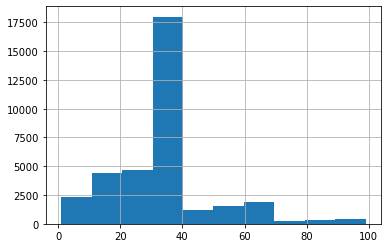

In [14]:
# Check range of hours for persons with ESR 1 or 4: not at work civilians or armed forces, but with a job
print(persons[(persons['ESR'] == 2) | (persons['ESR'] == 5)]['WKHP'].describe().compute())
pd.Series(persons[(persons['ESR'] == 2) | (persons['ESR'] == 5)]['WKHP']).hist()

# 8.7 ESR 4 or 5 have MIL of 1 or 3
Check if armed forces ESR 4 or 5 have an active duty status MIL of 1 or 3

In [15]:
# MIL codes for persons with ESR 4 or 5: armed forces
# MIL codes 1 and 3 code for those on active duty
persons[(persons['ESR'] == 4) | (persons['ESR'] == 5)]['MIL'].unique().compute()

0    1.0
1    3.0
Name: MIL, dtype: float64

# 8.8 Is there a pattern in COW values for those with MIL code != b or 4
For those in or used to be on active duty, what are COW values?

Mostly falls under COW 5, Federal government employee. Removing those that are on active duty brings the distribution closer to those that never served, but a large majority still work under the federal government.

0    5.0
1    1.0
2    0.0
3    2.0
4    6.0
5    7.0
6    3.0
7    4.0
8    9.0
9    8.0
Name: COW, dtype: float64


<AxesSubplot:>

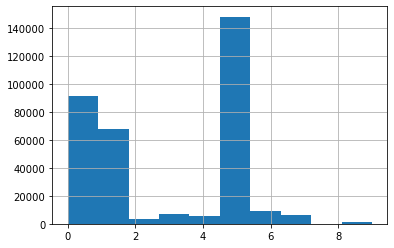

In [16]:
# Distribution of COW values for those in or used to be on active duty
print(persons[~((persons['MIL']==0) | (persons['MIL'] == 4))]['COW'].unique().compute())
pd.Series(persons[~((persons['MIL']==0) | (persons['MIL'] == 4))]['COW']).hist()

<AxesSubplot:>

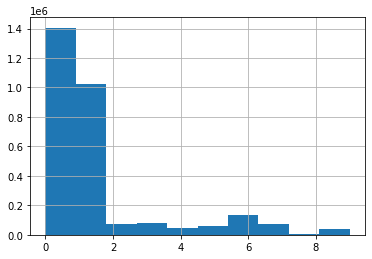

In [17]:
# Distribution of COW values for those that has never served
pd.Series(persons[(persons['MIL']==0) | (persons['MIL'] == 4)]['COW']).hist()

# 8.9  MIL b and ESR b have age < 17 
Check if MIL value less than 17 y/o and ESR value less than 16 (both values of 0) have all AGEP less than 17.

In [18]:
# Number of persons with ESR value less than 16 y/o, but AGEP greater than or equal to 17
persons[(persons['ESR'] == 0) & (persons['AGEP'] >= 17)].shape[0].compute()

0

In [19]:
# Number of persons with MIL value less than 16 y/o, but AGEP greater than or equal to 17
persons[(persons['MIL'] == 0) & (persons['AGEP'] >= 17)].shape[0].compute()

0

# 8.10 MIL 1 have ESR = 4 or 5
Check if MIL on active duty has ESR value for armed forces

In [20]:
persons[persons['MIL'] == 1]['ESR'].unique().compute()

0    4.0
1    5.0
Name: ESR, dtype: float64

# 8.11 ESR 4 or 5 have age <= 60

In [21]:
persons[((persons['ESR'] == 4) | (persons['ESR'] == 5)) & (persons['AGEP'] > 60)].shape[0].compute()

0

# 8.12 MIL 1 has isWorker 1 and ESR 4 or 5. Pattern in their COWs?
`isWorker` is removed and cannot be checked. ESR checked in 8.10.

In [22]:
persons[persons['MIL'] == 1]['COW'].unique().compute()

0    5.0
Name: COW, dtype: float64

# 8.13 MIL = 1 or 3 have age > 60

Check for all persons with `MIL` codes `1` or `3` (active duty) and over `AGEP` 60.

All persons that are on active duty and over `AGEP` 60 are only on active duty for training in Reserves/National Guard (`MIL` code `3`).

12940


<AxesSubplot:>

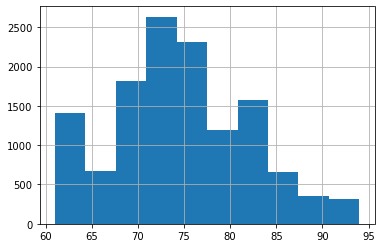

In [23]:
print(persons[((persons['MIL'] == 1) | (persons['MIL'] == 3)) & (persons['AGEP'] > 60)].shape[0].compute())
pd.Series(persons[((persons['MIL'] == 1) | (persons['MIL'] == 3)) & (persons['AGEP'] > 60)]['AGEP']).hist()

0


<AxesSubplot:>

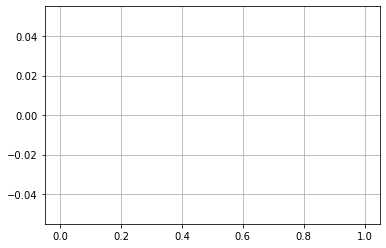

In [24]:
print(persons[(persons['MIL'] == 1) & (persons['AGEP'] > 60)].shape[0].compute())
pd.Series(persons[(persons['MIL'] == 1) & (persons['AGEP'] > 60)]['AGEP']).hist()

12940


<AxesSubplot:>

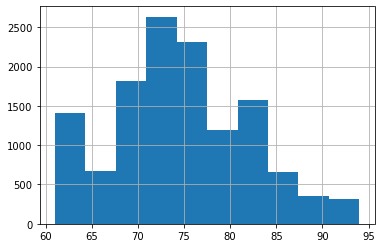

In [27]:
print(persons[(persons['MIL'] == 3) & (persons['AGEP'] > 60)].shape[0].compute())
pd.Series(persons[(persons['MIL'] == 3) & (persons['AGEP'] > 60)]['AGEP']).hist()

<AxesSubplot:>

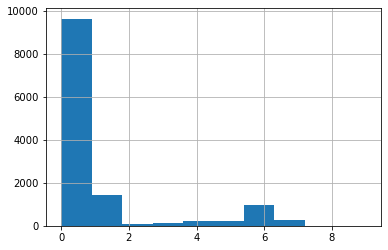

In [26]:
# Checks for 
pd.Series(persons[((persons['MIL'] == 1) | (persons['MIL'] == 3)) & (persons['AGEP'] > 60)]['COW']).hist()